In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import expm
from scipy.integrate import quad_vec

# **Extract Data**

In [ ]:
# Load CSV, skipping first 10 rows and selecting only relevant columns
file_path = "feds200628.csv"  # Ensure correct file path
columns_to_use = ["Date", "BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]

df = pd.read_csv(file_path, skiprows=9, usecols=columns_to_use)

# Convert Date column to datetime
df["Date"] = pd.to_datetime(df["Date"])

# Filter data for the period January 1995 - December 2024
df = df[(df["Date"] >= "1995-01-01") & (df["Date"] <= "2024-12-31")]


# Ensure that if the first trading day has missing data, move to the next available day
def get_first_valid_trading_day(group):
    return group.dropna(subset=["BETA0", "BETA1", "BETA2", "BETA3", "TAU1", "TAU2"]).iloc[0]

first_trading_day_params = df.groupby(df["Date"].dt.to_period("M")).apply(get_first_valid_trading_day).reset_index(drop=True)

# Define maturities (in years)
maturities = np.array([1/12,3/12,6/12,9/12,1,1.5, 2, 3, 5, 7, 10, 15, 20,30])

def nelson_siegel_svensson(beta0, beta1, beta2, beta3, tau1, tau2, maturities):
    """Calculate NSS yield curve for given maturities"""

    term = maturities  # Time to maturity
    factor1 = (1 - np.exp(-term / tau1)) / (term / tau1)
    factor2 = factor1 - np.exp(-term / tau1)
    factor3 = (1 - np.exp(-term / tau2)) / (term / tau2) - np.exp(-term / tau2)
    return beta0 + beta1 * factor1 + beta2 * factor2 + beta3 * factor3

# Nx360 matrix
monthly_yields = np.zeros(( len(maturities),len(first_trading_day_params)))

# Compute NSS yields for each month
for i, (_, row) in enumerate(first_trading_day_params.iterrows()):
    monthly_yields[:,i] = nelson_siegel_svensson(
        row["BETA0"], row["BETA1"], row["BETA2"], row["BETA3"],
        row["TAU1"], row["TAU2"], maturities
    )/100


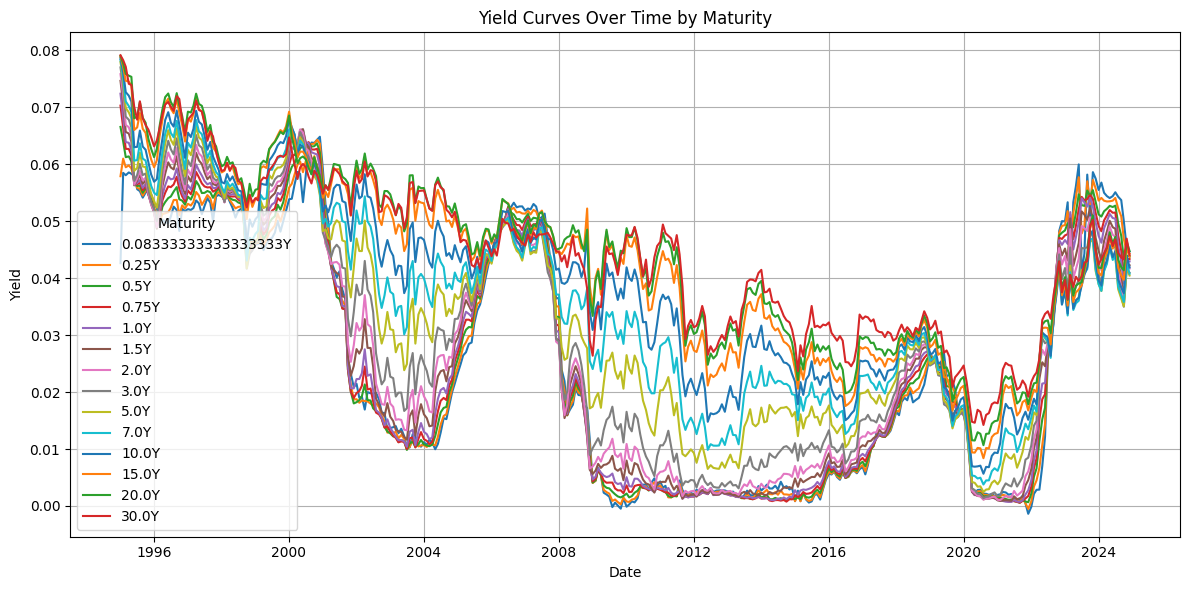

In [ ]:
# Plot yields over time for each maturity
plt.figure(figsize=(12, 6))

for i, maturity in enumerate(maturities):
    plt.plot(first_trading_day_params["Date"], monthly_yields[i, :], label=f"{maturity}Y")

plt.title("Yield Curves Over Time by Maturity")
plt.xlabel("Date")
plt.ylabel("Yield")
plt.legend(title="Maturity")
plt.grid(True)
plt.tight_layout()
plt.show()


# **KF for AFNS model (risk-neutral)**
goals:
- extract paths of each state factor (X_t)i
- extract covariance matrix between each (X_t)i at each time step t
- extract paths of rt from (X_t)[0] and (X_t)[1]
- extract paths of variance of rt

---

VAR[rt] = VAR[(X_t)[0] and (X_t)[1]]

remember VAR(X+Y)=VAR(X) + VAR(Y) + 2*Cov(X,Y)

---

- return likelihood for a given set of params

In [ ]:

def AFNS_kalman_filter(yields, maturities, Lambda, sigma, X0,p0,measurement_std,LL):
    # Number of time steps (in months) and maturities
    n_timesteps = yields.shape[1] #360
    n_maturities = len(maturities) #8
    n_factors=Lambda.shape[0] #3

    # 1 month
    dt = 1/12

    # Create arrays for storing results
    # NB not matrix- 1D arrays (1xn_timeteps)
    r_estimates = np.zeros(n_timesteps)
    var_rt_estimates=np.zeros(n_timesteps)
    # 3xT matrix but each column is not a column vector
    # X[:,1] is 1D array of length 3
    X_estimates = np.zeros((n_factors,n_timesteps))
    # (3x3)xT matrix each cov matrix IS a numpy matrix!
    # P[:,:,1] is 3x3 numpy matrix
    p_estimates = np.zeros((n_factors,n_factors,n_timesteps))

    #X0 and p0 are matrices 3x1 and 3x3
    # Set initial values
    r_estimates[0] = X0[0, 0] + X0[1, 0]     # Initial short rate process
    var_rt_estimates[0] = p0[0, 0] + p0[1, 1] + 2*p0[0, 1]
    X_estimates[:,0] = X0.flatten()          # Initial state process
    p_estimates[:,:,0] = p0            # Initial uncertainty

    # B(τ) coefficient
    L=Lambda[1,1] #scalar
    # these are 8x1 matrices
    B_tau_one = -maturities/maturities
    B_tau_two = (-(1 - np.exp(-L * maturities)) / L)/maturities
    B_tau_three = (L*np.exp(-L * maturities) - (1 - np.exp(-L * maturities)) / L)/maturities

    # 8x3 matrix
    B_tau = np.concatenate([B_tau_one, B_tau_two, B_tau_three], axis=1)

    # A(tau)
    # scalars
    alpha1 = sigma[0, 0]**2
    alpha2 = sigma[1, 0]**2 + sigma[1, 1]**2
    alpha3 = sigma[2, 0]**2 + sigma[2, 1]**2 + sigma[2, 2]**2
    alpha4 = sigma[0, 0] * sigma[1, 0]
    alpha5 = sigma[0, 0] * sigma[2, 0]
    alpha6 = sigma[1, 0] * sigma[2, 0] + sigma[1, 1] * sigma[2, 1]

    # Exponentials 8x1 matrices
    e_L_tau = np.exp(-L * maturities)
    e_2L_tau = np.exp(-2 * L * maturities)

    # all these are 8x1 matrices
    term1 = (alpha1 * maturities**2) / 6

    term2 = alpha2 * ((1 / (2 * L**2)) - (1 / L**3) * (1 - e_L_tau) / maturities + (1 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    term3 = alpha3 * ((1 / (2 * L**2)) + (1 / L**2) * e_L_tau - (1 / (4 * L)) * maturities * e_2L_tau - (3 / (4 * L**2)) * e_2L_tau - (2 / L**3) * (1 - e_L_tau) / maturities + (5 / (8 * L**3)) * (1 - e_2L_tau) / maturities)

    term4 = alpha4 * ((1 / 2*L) * maturities + (1 / L**2) * e_L_tau - (1 / L**3) * (1 - e_L_tau) / maturities)

    term5 = alpha5 * ((3 / L**2) * e_L_tau + (1 / 2*L) * maturities + (1 / L) * maturities * e_L_tau - (3 / L**3) * (1 - e_L_tau) / maturities)

    term6 = alpha6 * ((1 / L**2) + (1 / L**2) * e_L_tau - (1 / (2 * L**2)) * e_2L_tau - (3 / L**3) * (1 - e_L_tau) / maturities + (3 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    #8x1 matrix
    A_tau = (term1 + term2 + term3 + term4 + term5 + term6)

    # 8x3 matrix
    H = -B_tau
    # 8x1 matrix
    h = -A_tau #/ maturities

    # 3x3 matrix
    #A=(np.identity(n_factors)-Lambda)*dt
    #sigma is 3x3 matrix so this is 3x3 matrix
    #Q=(sigma @ sigma.T)*dt

    def compute_Q(KP, Sigma, t):
        """
        Compute the Q covariance matrix for a multivariate OU process:
        Q = ∫₀ᵗ e^{-KP s} Σ Σᵀ e^{-KPᵀ s} ds
        """

        def integrand(s):
            matrix_exponential_lambda = expm(-KP * s)
            return matrix_exponential_lambda @ Sigma @ Sigma.T @ matrix_exponential_lambda.T

        # Integrate element-wise
        Q, _ = quad_vec(integrand, 0, t)
        return Q

    Q = compute_Q(Lambda, sigma, dt)
    A = np.array(  np.exp(-Lambda*dt) ).reshape(3,3)


    # 8x8 matrix
    R = measurement_std**2 * np.identity(n_maturities)

    # Kalman filter iterations
    for t in range(1, n_timesteps):

        #---------- 1. PREDICTION STEP ----------#
        # 3x1 matrix
        X_predicted = A @ X_estimates[:, t-1].reshape(3,1)

        # 3x3 matrix
        p_predicted = A @ p_estimates[:, :, t-1] @ A.T + Q

        #---------- 2. UPDATE STEP ----------#
        # 8x1 matrix
        yields_predicted = h + H @ X_predicted

        # 8x1 matrix
        y_bar = yields[:, t].reshape(n_maturities, 1) - yields_predicted

        # 8x8 matrix
        F = H @ p_predicted @ H.T + R

        # 3x8 matrix
        K = p_predicted @ H.T @ np.linalg.inv(F)

        # Update state estimate
        #remeber each column of X is 1D array of length 3
        X_estimates[:, t] = (X_predicted + K @ y_bar).flatten()
        r_estimates[t] = X_estimates[0, t] + X_estimates[1, t] #scalar + scaler = scalar

        # Update uncertainty estimate
        #3x3 matrix
        term1 = np.identity(n_factors) - K @ H
        #3x3 matrix
        term2 = K @ R @ K.T

        #3x3 matrix
        #remember each double layer of P is 3x3 matrix so no need to flatten
        p_estimates[:, :, t] = term1 @ p_predicted @ term1.T + term2

        #VAR(X+Y)=VAR(X) + VAR(Y) + 2*Cov(X,Y)
        var_rt_estimates[t] = p_estimates[0, 0, t] + p_estimates[1, 1, t] + 2*p_estimates[0, 1, t]

        LL += log_likelihood_step(y_bar, F)

    return r_estimates, var_rt_estimates, X_estimates,LL

# **LL for 3 factor model**

In [ ]:
def log_likelihood_step(y_bar, F):

    dy = y_bar.shape[0]
    sign, logdet = np.linalg.slogdet(F)
    if sign != 1:
        raise ValueError("Covariance matrix is not positive definite")
    inv_F = np.linalg.inv(F)
    term1 = -0.5 * dy * np.log(2 * np.pi)
    term2 = -0.5 * logdet
    term3 = -0.5 * y_bar.T @ inv_F @ y_bar
    return (term1 + term2 + term3).item()

def negative_log_likelihood(params, yields, maturities, X0, p0, LL0):
    #params is 1D array not matrix
    lambda1 = params[0]
    sigma_flat = params[1:7]
    measurement_std = params[-1]

    # Construct Lambda matrix from lambda1 and lambda2
    Lambda = np.array([
        [0.0,      0.0,      0.0],
        [0.0,  lambda1,   -lambda1],
        [0.0,      0.0,   lambda1]
    ])

    # Reconstruct sigma as lower-triangular
    Sigma = np.zeros((3, 3))
    Sigma[np.tril_indices(3)] = sigma_flat

    # Kalman filter or log-likelihood calc
    _, _, _,neg_LL = AFNS_kalman_filter(
        yields, maturities, Lambda, Sigma, X0, p0, measurement_std, LL0
    )

    return -neg_LL



# **Test KF for AFNS**

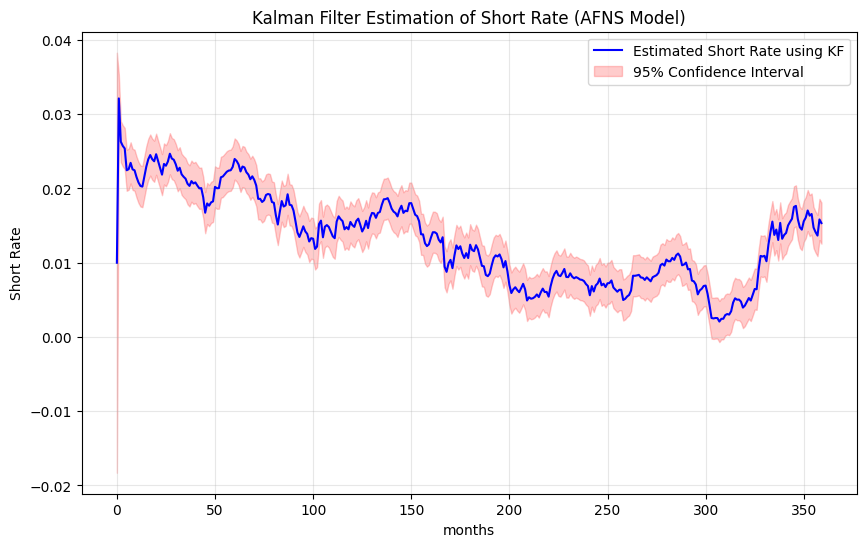

In [ ]:
#set inital values
# drift matrix
L=0.08
Lambda = np.array([
    [0.00, 0.00, 0.00],
    [0.00, -L, L],
    [0.00, 0.00, L]
])

# Volatility matrix (lower triangular)
sigma = np.array([
    [0.001, 0.00, 0.00],
    [0.005, 0.008, 0.00],
    [0.002, 0.003, 0.007]
])

# Initial latent state
X0 = np.array([0.02, -0.01, 0.005]).reshape(3, 1)

# Initial uncertainty cov matrix
p0 = np.eye(3) * 0.0001

# Measurement noise
measurement_noise = 0.002  # 2 bps

# Maturities (in years)
maturities = np.array([1, 2, 3, 5, 7, 10, 15, 20]).reshape(8, 1)
monthly_yields=monthly_yields.reshape(8,360)

#Log likelihood initialisation
LL0=0

# Apply Kalman filter
estimated_rates, estimated_variances,estimated_state_factors,LL= AFNS_kalman_filter(
  monthly_yields, maturities,Lambda, sigma, X0,p0,measurement_noise,LL0
)


# Compute standard deviation from variance
std_dev = np.sqrt(estimated_variances)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(estimated_rates, 'b-', label='Estimated Short Rate using KF')

# Add confidence bands (±2 standard deviations)
plt.fill_between(
    np.arange(monthly_yields.shape[1]),
    estimated_rates - 2 * std_dev,
    estimated_rates + 2 * std_dev,
    color='red', alpha=0.2, label='95% Confidence Interval'
)

plt.title('Kalman Filter Estimation of Short Rate (AFNS Model)')
plt.xlabel('months')
plt.ylabel('Short Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


# **Use LL & KF to get opt RN params for AFNS model**

Estimated Lambda matrix:
[[ 0.          0.          0.        ]
 [ 0.          1.74872654 -1.74872654]
 [ 0.          0.          1.74872654]]

Estimated sigma matrix:
[[ 0.01977836  0.          0.        ]
 [-0.09103168  0.10915944  0.        ]
 [-0.07082898  0.11690075  0.00428002]]

Estimated measurement noise: 0.005112

LL: 16740.478847


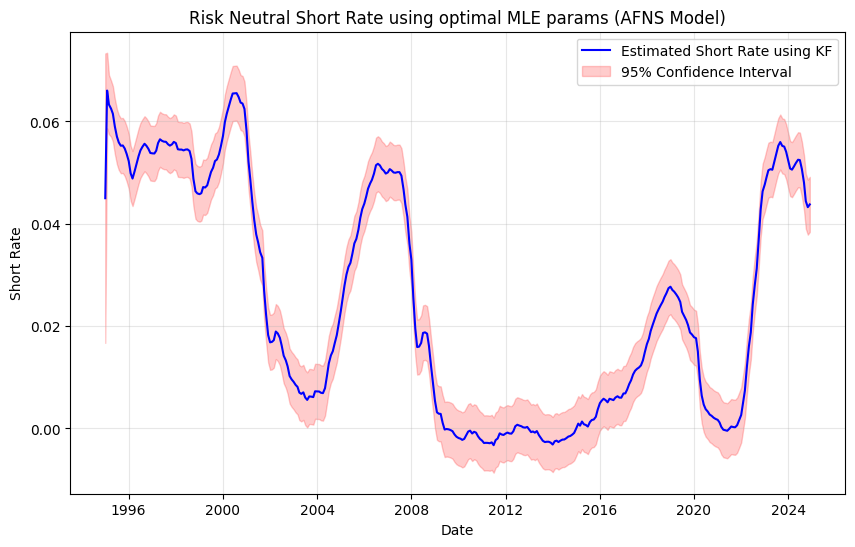

In [ ]:
#set inital values
# Volatility matrix (lower triangular)
sigma = np.array([
    [0.01, 0, 0],
    [0.005, 0.018, 0],
    [0.002, 0.003, 0.017]
])



# Maturities (in years)
maturities = np.array([1/12,3/12,6/12,9/12,1,1.5, 2, 3, 5, 7, 10, 15, 20,30]).reshape(-1,1)

#Log likelihood initialisation
LL0=0

initial_lambda = [0.4]
initial_sigma = sigma[np.tril_indices(3)]
initial_measurement_std = [0.002]

# Initial latent state
X0 = np.array([0.055, -0.01, 0.005]).reshape(3, 1)

# Initial uncertainty
p0 = np.eye(3) * 0.0001

initial_guess = np.concatenate([initial_lambda, initial_sigma, initial_measurement_std])


bounds = []
bounds += [(1e-3, 5)]    # lambda
bounds += [(-1, 1)] * 6        # lower-triangle sigma
bounds += [(1e-5, 0.01)]           # measurement noise


result = minimize(
    negative_log_likelihood,
    initial_guess,
    args=(monthly_yields, maturities, X0, p0,LL0),
    bounds=bounds,
    method='L-BFGS-B'
)
# Unpack result vector
lambda1 = result.x[0]
sigma_flat = result.x[1:7]
estimated_noise = result.x[-1]

# Reconstruct Lambda
estimated_Lambda = np.array([
    [0,       0,       0],
    [0,   lambda1,    -lambda1],
    [0,       0,    lambda1]
])

# Reconstruct sigma (lower triangular)
estimated_sigma = np.zeros((3, 3))
estimated_sigma[np.tril_indices(3)] = sigma_flat

# Print nicely
print("Estimated Lambda matrix:")
print(estimated_Lambda)
print("\nEstimated sigma matrix:")
print(estimated_sigma)
print(f"\nEstimated measurement noise: {estimated_noise:.6f}")


# Apply Kalman filter
estimated_rates_opt, estimated_variances_opt,estimated_state_factors_opt,LL_opt= AFNS_kalman_filter(
  monthly_yields, maturities,estimated_Lambda, estimated_sigma, X0,p0,estimated_noise,LL0
)
print(f"\nLL: {LL_opt:.6f}")

# Plot results
# Compute standard deviation from variance
std_dev = np.sqrt(estimated_variances_opt)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(first_trading_day_params["Date"],estimated_rates_opt, 'b-', label='Estimated Short Rate using KF')

# Add confidence bands (±2 standard deviations)
plt.fill_between(
    first_trading_day_params["Date"],
    estimated_rates_opt - 2 * std_dev,
    estimated_rates_opt + 2 * std_dev,
    color='red', alpha=0.2, label='95% Confidence Interval'
)

plt.title('Risk Neutral Short Rate using optimal MLE params (AFNS Model)')
plt.xlabel('Date')
plt.ylabel('Short Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# **Compare KF Yields to historical Yields**

In [ ]:
def AFNS_yield_curve(X_t, Lambda, sigma, maturities):
  #given a state process and the afns model params under Q we can reconstruct yields at various maturities and compare with historical data
    L=Lambda[1,1] #scalar
    # these are 8x1 matrices
    B_tau_one = -maturities/maturities
    B_tau_two = (-(1 - np.exp(-L * maturities)) / L)/maturities
    B_tau_three = (L*np.exp(-L * maturities) - (1 - np.exp(-L * maturities)) / L)/maturities

    # 8x3 matrix
    B_tau = np.concatenate([B_tau_one, B_tau_two, B_tau_three], axis=1)

    # A(tau)
    # scalars
    alpha1 = sigma[0, 0]**2
    alpha2 = sigma[1, 0]**2 + sigma[1, 1]**2
    alpha3 = sigma[2, 0]**2 + sigma[2, 1]**2 + sigma[2, 2]**2
    alpha4 = sigma[0, 0] * sigma[1, 0]
    alpha5 = sigma[0, 0] * sigma[2, 0]
    alpha6 = sigma[1, 0] * sigma[2, 0] + sigma[1, 1] * sigma[2, 1]

    # Exponentials 8x1 matrices
    e_L_tau = np.exp(-L * maturities)
    e_2L_tau = np.exp(-2 * L * maturities)

    # all these are 8x1 matrices
    term1 = (alpha1 * maturities**2) / 6

    term2 = alpha2 * ((1 / (2 * L**2)) - (1 / L**3) * (1 - e_L_tau) / maturities + (1 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    term3 = alpha3 * ((1 / (2 * L**2)) + (1 / L**2) * e_L_tau - (1 / (4 * L)) * maturities * e_2L_tau - (3 / (4 * L**2)) * e_2L_tau - (2 / L**3) * (1 - e_L_tau) / maturities + (5 / (8 * L**3)) * (1 - e_2L_tau) / maturities)

    term4 = alpha4 * ((1 / 2*L) * maturities + (1 / L**2) * e_L_tau - (1 / L**3) * (1 - e_L_tau) / maturities)

    term5 = alpha5 * ((3 / L**2) * e_L_tau + (1 / 2*L) * maturities + (1 / L) * maturities * e_L_tau - (3 / L**3) * (1 - e_L_tau) / maturities)

    term6 = alpha6 * ((1 / L**2) + (1 / L**2) * e_L_tau - (1 / (2 * L**2)) * e_2L_tau - (3 / L**3) * (1 - e_L_tau) / maturities + (3 / (4 * L**3)) * (1 - e_2L_tau) / maturities)

    #8x1 matrix
    A_tau = (term1 + term2 + term3 + term4 + term5 + term6)

    # 8x3 matrix
    H = -B_tau
    # 8x1 matrix
    h = -A_tau #/ maturities


    n_steps = X_t.shape[1]
    n_maturities = len(maturities)
    KF_yields = np.zeros((n_maturities,n_steps))

    for t in range(n_steps):
          KF_yields[:, t] = (h + H @ X_t[:,t].reshape(-1,1)).flatten()

    return KF_yields


KF_yields = AFNS_yield_curve(
    estimated_state_factors_opt, estimated_Lambda, estimated_sigma, maturities
)


print(f"{'Maturity (Years)':<20}{'MSE':<15}{'R^2':<10}")
print("-" * 45)

for i in range(len(maturities)):
    observed = monthly_yields[i, 1:]
    estimated = KF_yields[i, 1:]

    mse = mean_squared_error(observed, estimated)
    r2 = r2_score(observed, estimated)

    print(f"{maturities[i].item():<20.2f}{mse:<15.6f}{r2:<10.4f}")

total_mse = mean_squared_error(monthly_yields.flatten(), KF_yields.flatten())
total_r2 = r2_score(monthly_yields.flatten(), KF_yields.flatten())
# AIC and BIC calculation
num_params = 8  # short rate model has 8 parameters
AIC = 2 * num_params - 2 * LL_opt
BIC = np.log(14*360) * num_params - 2 * LL_opt

print("\n" + "-" * 45)
print(f"{'Total MSE:':<20}{total_mse:.6f}")
print(f"{'Total R^2:':<20}{total_r2:.4f}")
print(f"{'AIC:':<20}{AIC:.2f}")
print(f"{'BIC:':<20}{BIC:.2f}")

Maturity (Years)    MSE            R^2       
---------------------------------------------
0.08                0.000000       0.9994    
0.25                0.000003       0.9935    
0.50                0.000007       0.9846    
0.75                0.000012       0.9754    
1.00                0.000015       0.9682    
1.50                0.000018       0.9606    
2.00                0.000018       0.9591    
3.00                0.000014       0.9651    
5.00                0.000006       0.9804    
7.00                0.000007       0.9757    
10.00               0.000016       0.9385    
15.00               0.000035       0.8617    
20.00               0.000045       0.8114    
30.00               0.000049       0.7521    

---------------------------------------------
Total MSE:          0.000020
Total R^2:          0.9532
AIC:                -33464.96
BIC:                -33412.76


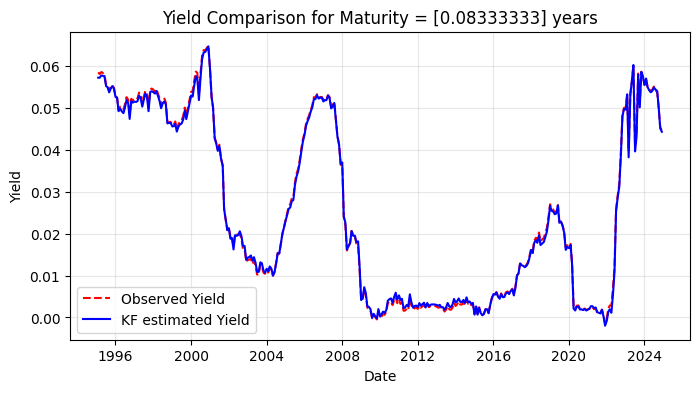

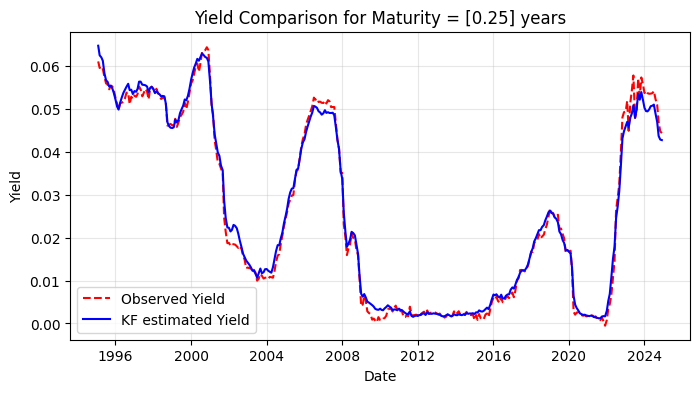

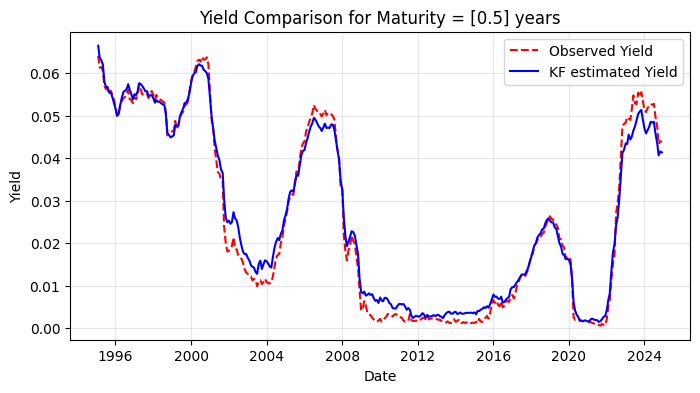

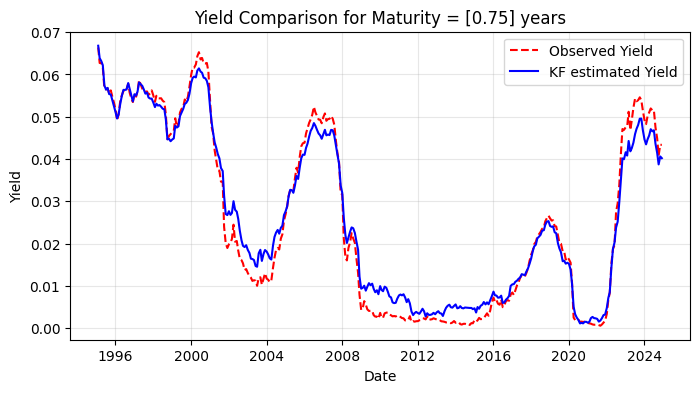

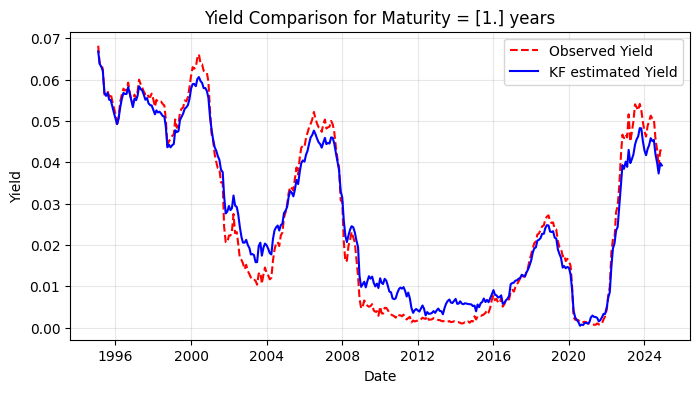

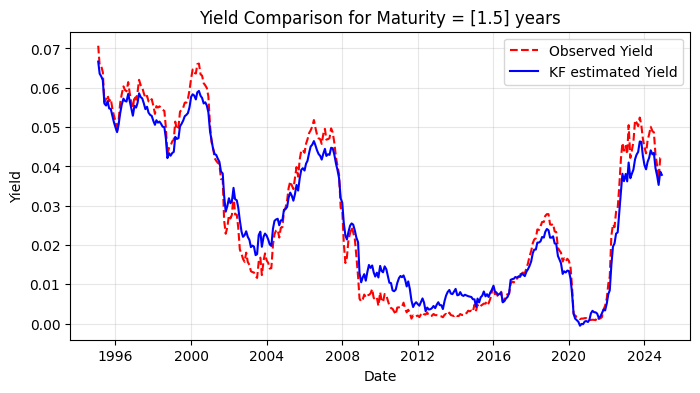

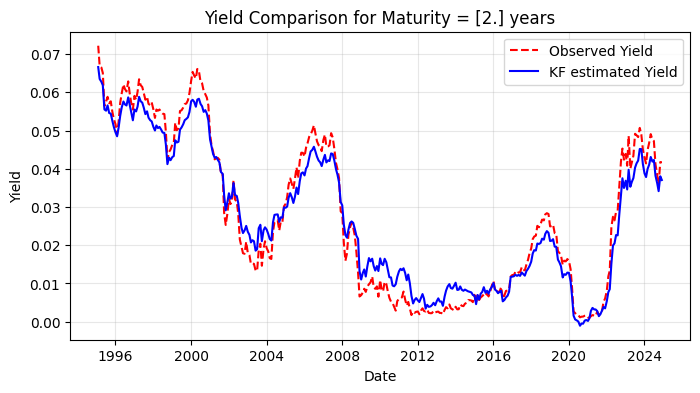

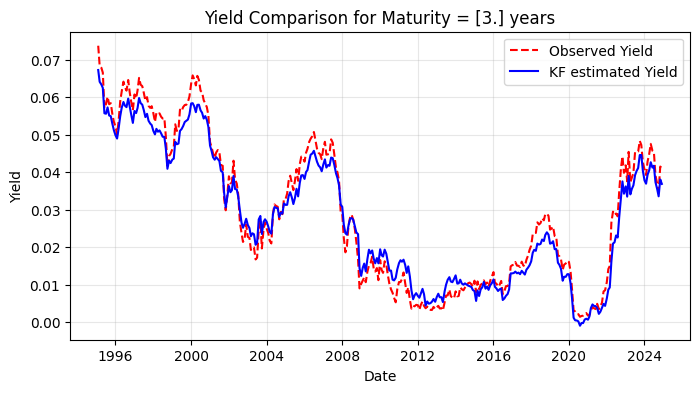

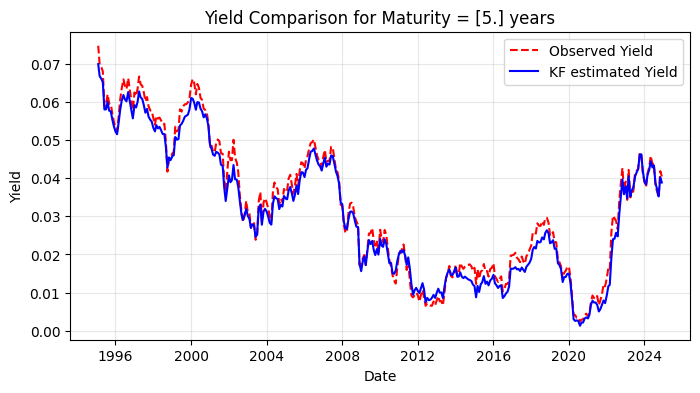

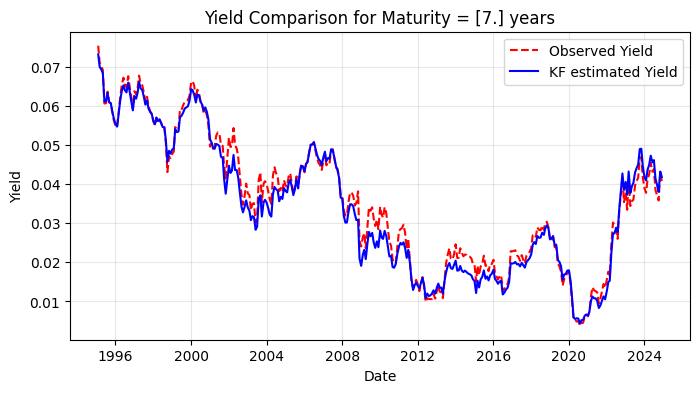

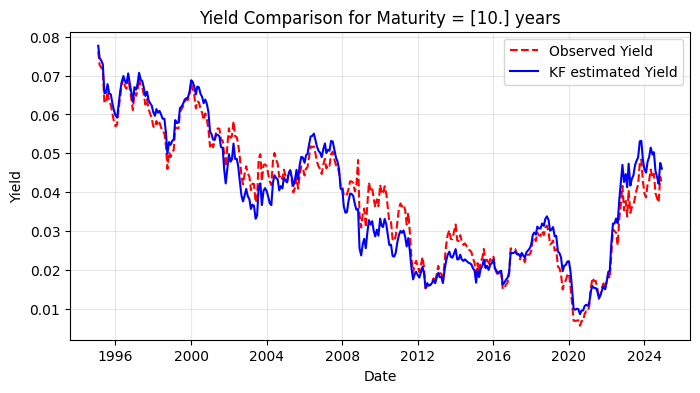

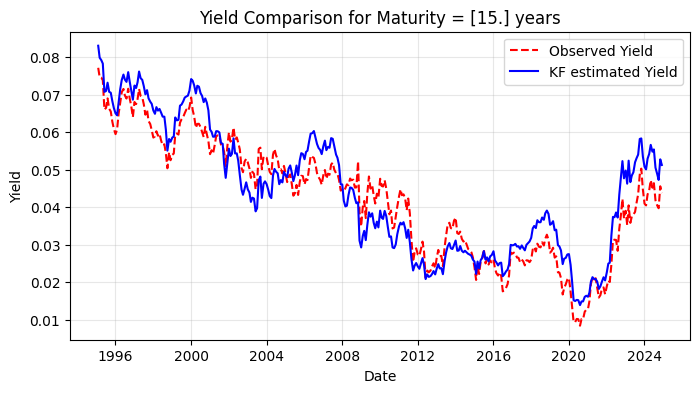

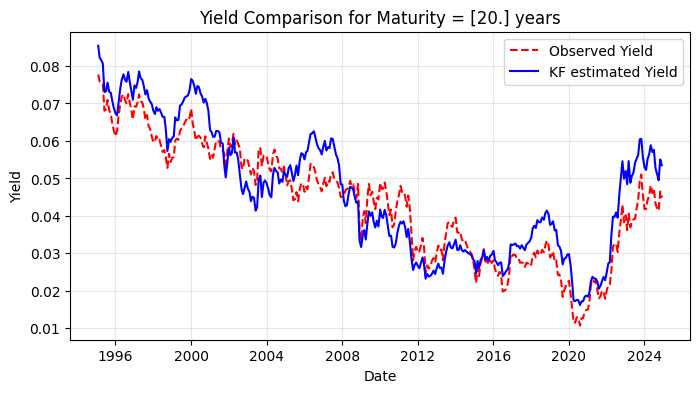

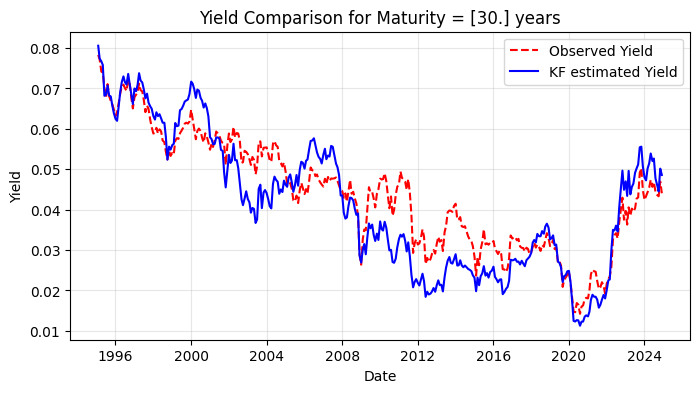

In [ ]:
for i in range(len(maturities)):
    plt.figure(figsize=(8, 4))
    plt.plot(first_trading_day_params["Date"][1:],monthly_yields[i,1:], 'r--', label='Observed Yield')
    plt.plot(first_trading_day_params["Date"][1:],KF_yields[i,1:], 'b-', label='KF estimated Yield')
    plt.title(f'Yield Comparison for Maturity = {maturities[i]} years')
    plt.xlabel('Date')
    plt.ylabel('Yield')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()